### CNN Modeling
---
**Goal:** Fit multi-label classification model on the train set. Finally, score on test set.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
embedding_dim = 100
glove_path = '../dataset/glove/glove.6B.100d.txt'
# glove is too big, so it isnt uploaded to github

embeddings_index = {}
with open(glove_path, encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [3]:
# Load the preprocessed data
# those file had been deleted now
train_path = "../dataset/Task3preprocessed/netflix_train.csv"
val_path = "../dataset/Task3preprocessed/netflix_val.csv"
test_path = "../dataset/Task3preprocessed/netflix_test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Combine title and description for each sample
train_text = train_data['title'] + ' ' + train_data['description']
val_text = val_data['title'] + ' ' + val_data['description']
test_text = test_data['title'] + ' ' + test_data['description']

# Tokenize the text data
max_words = 5000  # Adjust based on your dataset
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_text)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_text)
val_sequences = tokenizer.texts_to_sequences(val_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

# Pad sequences for consistent input length
max_len = 300  # Adjust based on your dataset
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [4]:
train_labels = train_data.iloc[:, 4:].values
val_labels = val_data.iloc[:, 4:].values
test_labels = test_data.iloc[:, 4:].values

print("Train description num:", len(train_padded))
print("Train Label num:", len(train_labels))
print("Train Label dataset:", train_labels)
print("Label num:",train_labels.shape[1])

训练数据集样本description数: 6164
训练标签集数: 6164
训练标签集: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
训练标签数: 42


In [5]:
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [6]:
# Build the CNN model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),  # 设置 trainable=False 表示不再训练词嵌入层
    Conv1D(128, 5, activation='relu'),
    Conv1D(64, 3, activation='relu'),
    Conv1D(32, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(train_labels.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          500100    
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          64128     
                                                                 
 conv1d_1 (Conv1D)           (None, 294, 64)           24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 292, 32)           6176      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                        

In [7]:
history = model.fit(train_padded, train_labels, epochs=30, batch_size=32, validation_data=(val_padded, val_labels))

Epoch 1/30
193/193 [==============================] - 11s 51ms/step - loss: 0.3546 - accuracy: 0.0556 - val_loss: 0.1762 - val_accuracy: 0.1158
Epoch 2/30
193/193 [==============================] - 9s 49ms/step - loss: 0.2047 - accuracy: 0.0985 - val_loss: 0.1740 - val_accuracy: 0.1862
Epoch 3/30
193/193 [==============================] - 10s 53ms/step - loss: 0.1939 - accuracy: 0.1296 - val_loss: 0.1732 - val_accuracy: 0.1862
Epoch 4/30
193/193 [==============================] - 10s 49ms/step - loss: 0.1874 - accuracy: 0.1491 - val_loss: 0.1683 - val_accuracy: 0.2082
Epoch 5/30
193/193 [==============================] - 9s 46ms/step - loss: 0.1794 - accuracy: 0.1645 - val_loss: 0.1645 - val_accuracy: 0.1855
Epoch 6/30
193/193 [==============================] - 9s 46ms/step - loss: 0.1742 - accuracy: 0.1668 - val_loss: 0.1642 - val_accuracy: 0.1961
Epoch 7/30
193/193 [==============================] - 9s 47ms/step - loss: 0.1709 - accuracy: 0.1901 - val_loss: 0.1637 - val_accuracy: 0.2

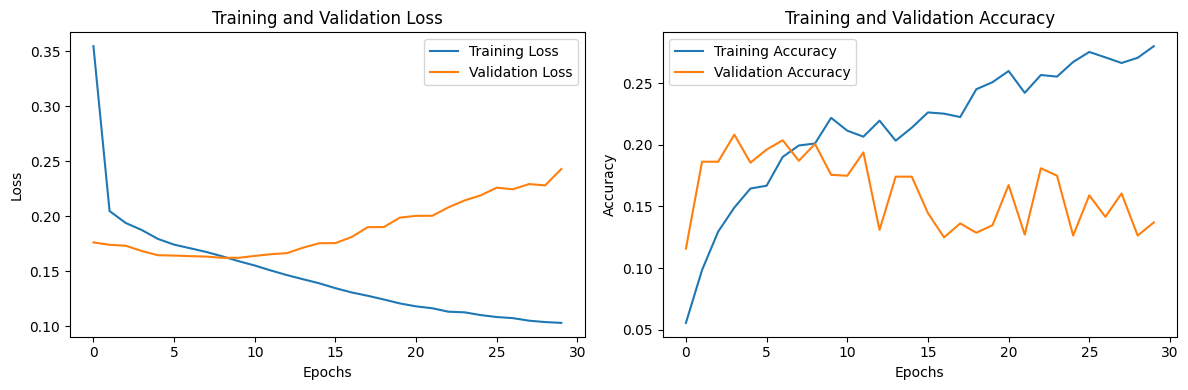

In [8]:
plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:

test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f'Test Accuracy: {test_acc}')

42/42 [==============================] - 0s 9ms/step - loss: 0.2450 - accuracy: 0.1672
Test Accuracy: 0.1671709567308426


In [10]:
predictions = model.predict(test_padded)
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))

print("Confusion Matrix:")
print(conf_matrix)

42/42 [==============================] - 0s 9ms/step
Confusion Matrix:
[[ 0  0  0 ...  0  5  1]
 [ 0  0  0 ...  0  3  2]
 [ 0  0  0 ...  0  4  3]
 ...
 [ 0  0  0 ...  0  1  2]
 [ 0  0  0 ...  0 12  5]
 [ 0  0  0 ...  0  0  6]]


In [11]:
report = classification_report(test_labels, predictions > 0.5, target_names=list(train_data.columns[4:]))
print("Classification Report:")
print(report)

Classification Report:
                              precision    recall  f1-score   support

          Independent Movies       0.00      0.00      0.00       122
              Anime Features       0.00      0.00      0.00        17
                   TV Dramas       0.00      0.00      0.00       118
             Stand-Up Comedy       0.74      0.47      0.58        59
             Romantic Movies       0.00      0.00      0.00        85
                Anime Series       0.00      0.00      0.00        26
          Action & Adventure       0.37      0.15      0.21       126
                      Movies       0.00      0.00      0.00         9
        International Movies       0.48      0.48      0.48       418
Stand-Up Comedy & Talk Shows       0.00      0.00      0.00         6
               Sports Movies       0.00      0.00      0.00        25
                LGBTQ Movies       0.00      0.00      0.00        14
                   TV Horror       0.00      0.00      0.00       

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
